In [1]:
import pandas as pd
import numpy as np

import gzip
import cPickle as pickle
import glob

from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import sklearn
from sklearn.preprocessing import normalize, StandardScaler

import calendar
import datetime, time

import gc
import os

import matplotlib
import matplotlib.pyplot as plt
% matplotlib inline

In [3]:
in_dir = "/home/data/kaggle-zillow/processed/"

out_dir = "/home/data/kaggle-zillow/submissions/"

if not os.path.exists(out_dir):
    os.makedirs(out_dir)

# Load formatted data

In [104]:
# training data

with gzip.open(in_dir + "/train_formatted.pickle.gz", "r") as f:
    train_data = pickle.load(f)
    
X_train, y_train, X_eval, y_eval = \
    train_data['X_train'], train_data['y_train'], train_data['X_test'], train_data['y_test']

features, categ_vars = \
    train_data['features'], train_data['categ_vars']

print X_train.shape

(89372, 48)


In [105]:
ulimit = np.percentile(y_train, 99)
llimit = np.percentile(y_train, 1)
idx = (y_train > llimit) & (y_train < ulimit)
X_train = X_train[idx,:]
y_train = y_train[idx]

In [106]:
# test data

test_df = pd.read_csv(in_dir + "/sample_formatted.csv")
test_df.insert(test_df.shape[1], 'transactionmonth', 0)
X_test = test_df[features].values

In [107]:
X_train.shape, X_test.shape

((87582, 48), (2985217, 48))

# LGB model

### Train model

In [109]:
# apparently light GBM wants categorical features as integers
    
X_train_lgb = X_train.copy()
X_test_lgb = X_test.copy()
X_eval_lgb = X_eval.copy()
    
for c in categ_vars:
    X_train_lgb[:,features.index(c)] = X_train[:,features.index(c)].astype(int)    
    X_test_lgb[:,features.index(c)] = X_test[:,features.index(c)].astype(int)
    X_eval_lgb[:,features.index(c)] = X_eval_lgb[:,features.index(c)].astype(int)

In [122]:
d_train = lgb.Dataset(X_train_lgb, label=y_train, free_raw_data=False)
d_eval  = lgb.Dataset(X_eval_lgb, label=y_eval)

params = {}
params['max_bin'] = 200
params['learning_rate'] = 0.02 # shrinkage_rate
params['boosting_type'] = 'dart' # alternative: 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'l1'          # or 'mae'
params['lambda_l2'] = 1       # L2 regularization
params['sub_feature'] = 0.6      # feature_fraction -- OK, back to .5, but maybe later increase this
params['bagging_fraction'] = 0.8 # sub_row
params['bagging_freq'] = 20
params['num_leaves'] = 512        # num_leaf
params['min_data'] = 200         # min_data_in_leaf
params['min_hessian'] = 0.05     # min_sum_hessian_in_leaf
params['verbose'] = 1

# params['device'] = 'gpu'
# params['gpu_platform_id'] = 0
# params['gpu_device_id'] = 0


# Use large max_bin (may be slower)
# Use small learning_rate with large num_iterations
# Use large num_leaves(may cause over-fitting)


In [ ]:
N_FOLDS = 5

cv_results = lgb.cv(params, d_train, num_boost_round=1000, nfold=N_FOLDS, 
                    verbose_eval=10, early_stopping_rounds=40)
print('Current parameters:\n', params)
print('\nBest num_boost_round:', len(cv_results['l1-mean']))
print('Best CV score:', cv_results['l1-mean'][-1])

[10]	cv_agg's l1: 0.0530473 + 0.000334911
[20]	cv_agg's l1: 0.0529232 + 0.000328836
[30]	cv_agg's l1: 0.0528248 + 0.000326715
[40]	cv_agg's l1: 0.0527673 + 0.000323101
[50]	cv_agg's l1: 0.0526818 + 0.000319855
[60]	cv_agg's l1: 0.0526021 + 0.000319616
[70]	cv_agg's l1: 0.0525562 + 0.000321024
[80]	cv_agg's l1: 0.0525349 + 0.000322041
[90]	cv_agg's l1: 0.052539 + 0.000324324
[100]	cv_agg's l1: 0.0525101 + 0.000322057
[110]	cv_agg's l1: 0.0525047 + 0.000323143
[120]	cv_agg's l1: 0.0524677 + 0.000321746
[130]	cv_agg's l1: 0.0524522 + 0.000322854
[140]	cv_agg's l1: 0.0524322 + 0.000322117
[150]	cv_agg's l1: 0.0524264 + 0.000321077
[160]	cv_agg's l1: 0.0524267 + 0.000321784
[170]	cv_agg's l1: 0.0524001 + 0.000318879
[180]	cv_agg's l1: 0.0523908 + 0.000319497
[190]	cv_agg's l1: 0.0523798 + 0.000318329
[200]	cv_agg's l1: 0.0523759 + 0.00031858
[210]	cv_agg's l1: 0.0523716 + 0.000321994


In [135]:
best_score = cv_results['l1-mean'][-1]
# best_score = clf.best_score['valid_0']['l1']

print best_score, len(cv_results['l1-mean'])

0.0523681675507 245


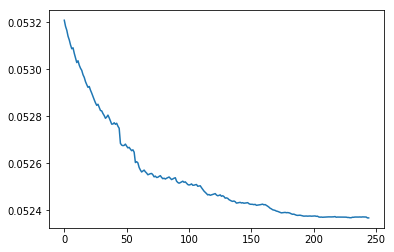

In [136]:
plt.plot(cv_results['l1-mean'])

In [137]:
print("\nFitting LightGBM model ...")

num_boost_rounds = len(cv_results['l1-mean'])
print "# boosting rounds:", num_boost_rounds

clf = lgb.train(params, d_train,
                num_boost_round=num_boost_rounds,
                # valid_sets=d_eval,
                feature_name=features,
                categorical_feature=categ_vars) #early_stopping_rounds=40)



Fitting LightGBM model ...
# boosting rounds: 245


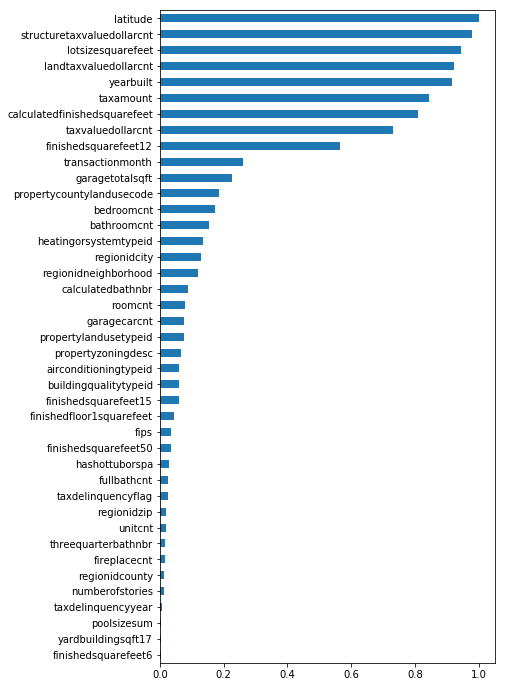

In [138]:
feature_importance = pd.Series(dict(zip(clf.feature_name(), clf.feature_importance())))
feature_importance = feature_importance / float(feature_importance.max())

feature_importance.sort_values(inplace=True)
feature_importance[feature_importance>0].plot(kind="barh", figsize=(6,12))

In [159]:
model_file = out_dir + '/model_%2.5f.txt'% best_score

print "Saving best model (score : %2.5f)" % best_score
print model_file

clf.save_model(model_file, num_iteration=clf.best_iteration)

# also save feature importance
pd.DataFrame(feature_importance).reset_index()\
    .rename(columns={"index":"feature", 0:"importance"})\
    .to_csv(out_dir + "/feature_importance.csv", header=["feature", "importance"], index=False)

Saving best model (score : 0.05237)
/home/data/kaggle-zillow/submissions//model_0.05237.txt


### Predict on test data and format for submission

In [140]:
model_files = glob.glob(out_dir + "model_*.txt")
model_files = {f:float(os.path.basename(f).replace("model_","").replace(".txt","")) for f in model_files}


In [141]:
idx = model_files.values().index(min(model_files.values()))
best_model_file = model_files.keys()[idx]
best_score = model_files[best_model_file]
best_model_file

'/home/data/kaggle-zillow/submissions/model_0.05237.txt'

In [142]:
print("\nStart LightGBM prediction ...")
# num_threads > 1 will predict very slow in kernal

bst = lgb.Booster(model_file=best_model_file) #init model

# bst.reset_parameter({"num_threads":8})

# the only difference in the submission columns is the value of the month for which the prediction is being made
# so let's set the value of the respective dummy column to 1

smpl_cols = ["201610", "201611", "201612", "201710", "201711", "201712"]

submission = {}
x = X_test.copy()
for c in smpl_cols:
    i = int(c[-2:])
    print "Making predictions for %s" % (c)
    x[:,features.index("transactionmonth")] = i
    submission[c] = bst.predict(x)

submission = pd.DataFrame(submission)
submission['ParcelId'] = test_df['parcelid']
submission.set_index('ParcelId', inplace=True)


Start LightGBM prediction ...
Making predictions for 201610
Making predictions for 201611
Making predictions for 201612
Making predictions for 201710
Making predictions for 201711
Making predictions for 201712


In [143]:
cur_date = datetime.datetime.now()
filename = cur_date.strftime("%y-%m-%d_%H:%M:%S") + "_%2.5f.csv"%best_score

submission.to_csv(out_dir + "/" + filename)